In [487]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec as gs 
import matplotlib as mpl
from cycler import cycler
import geopandas as gpd

In [538]:
import umap, umap.plot
from sklearn.cluster import KMeans

In [143]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": 'computer modern roman'})

In [393]:
sintetico = pd.read_csv('data/sintetico.csv')
def correctNUTS(df): df.DICOFRE = df.DICOFRE.str.zfill(6); return df.replace('Terras de Trás-Os-Montes', 'Terras de Trás-os-Montes')
info = correctNUTS(pd.read_csv('~/proj/geo/nuts_portugal.csv'))

- Europe
   - elbow
   - countries per cluster
   - portuguese nuts walking
- view
    - plot global along the years, with each nut 3 seperate and nut 2 with diff color
    - plot synth seperate R3->R2, with each NUT in a diff color
- disenbalances
    - plot nuts along years
    - plot country diff 2000->2020 for all variables with «>»-«<»

 # Europe

In [707]:
eurostat = pd.read_csv('/home/boturon/download/clean.csv', index_col=0)
euro = gpd.read_file("/home/boturon/download/NUTS_RG_60M_2021_3035.shp.zip")
euro_clusters = pd.Series({x:KMeans(n_clusters=x, random_state=0).fit(eurostat).inertia_ for x in range(2,20)})

In [711]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(eurostat).labels_
mapped = np.genfromtxt('data/embed.csv', delimiter=',')

In [772]:
def sliceEurostat(df_in, ks, year): df = df_in.copy(); df['k'] = ks; df = df[df.index.str[:4]==str(year)]; df.index = df.index.str[5:]; return df

In [776]:
def addEuro(geodf,dic): df = geodf[geodf.LEVL_CODE==3].copy(); df['metric'] = df.NUTS_ID.map(dic); return df

In [804]:
def plotClusterEU(geodf, df, color, filename, ncluster, precalc):

    mosaic = '''
    ABD
    '''
    euro_clusters, kmeans, mapped = precalc
    
    f, ax = plt.subplot_mosaic(mosaic, constrained_layout=True, dpi=200, figsize=(6,4))
    
    addEuro(geodf, sliceEurostat(df, kmeans, 2000).k.to_dict())\
    .plot(column='metric', ax=ax["A"], cmap=color, edgecolor="k", linewidth=0.05)
    ax["A"].set_axis_off(); ax["A"].set_title(2000)
        
    euro_clusters.plot(c='k', ax=ax['B'])
    ax['B'].set_title('Método do cotovelo'); 
    ax['B'].set_xlabel('Número de clusters'); ax['A'].set_ylabel('Inércia')
    ax['B'].axvline(ncluster, linestyle=':', c='k')

    # ax['C'].scatter(mapped[:,0], mapped[:,1], s=0.5, c=kmeans, cmap=color)
    # ax['C'].set_xticks([]); ax['C'].set_yticks([])
    # ax['C'].set_title('Redução de dimensões')

    addEuro(geodf, sliceEurostat(df, kmeans, 2019).k.to_dict())\
    .plot(column='metric', ax=ax["D"], cmap=color, edgecolor="k", linewidth=0.05)
    ax["D"].set_axis_off(); ax["D"].set_title(2019)
    
    for filetype in ["png","pdf"]: plt.savefig(f'graphs/{filename}_{ncluster}.{filetype}', dpi=200, bbox_inches='tight')
    plt.show()

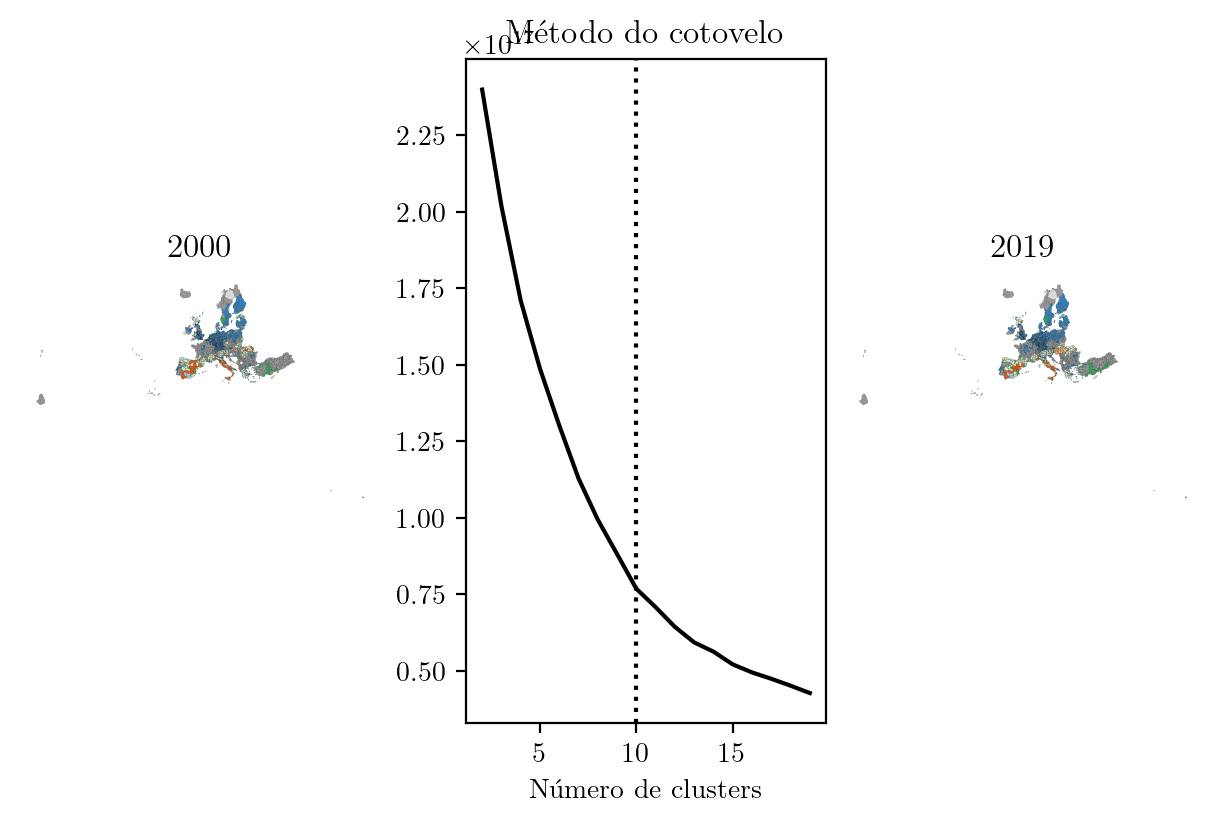

In [805]:
plotClusterEU(euro, eurostat, 'tab20c', 'euro', 10, (euro_clusters, kmeans, mapped))

# View

## INE

In [293]:
def sortColumns(df): return df.iloc[:,df.columns.str.normalize('NFKD').argsort()]
def convertTime(df): df.index = pd.to_datetime(df.index, format='%Y'); return df

In [917]:
def plotGeral(df, filename):
    n = 11#int(frame.shape[1]/2)
    new_colors = [plt.get_cmap('tab20c')(1. * i/n) for i in range(n)]
    f, ax = plt.subplots(1, 1, dpi=200, figsize=(8,4), tight_layout=True)
    ax.set_prop_cycle(cycler('linestyle', ['-', '--',':', '-.']) *cycler('color', new_colors)) 
    convertTime(sortColumns(df.pivot(index='year', columns='nut3', values='geral'))).plot(ax=ax)
    plt.legend(ncol=2, frameon=False, loc='center left', bbox_to_anchor=(1, 0.5), title="NUTS III")
    ax.set_xlabel('Ano'); ax.set_ylabel('Índice');
    plt.title('Índice sintético de\ndesenvolvimento regional')
    
    plt.tight_layout()
    for filetype in ["png","pdf"]: plt.savefig(f'graphs/{filename}.{filetype}', dpi=200, bbox_inches='tight')
    plt.show()

## geo

In [394]:
# dicts
dicofre2nut = info.set_index("DICOFRE").NUTSIII_COD.to_dict()
nut2name = info.set_index('NUTSIII_COD').NUTSIII_DSG.to_dict()
def reverseDic(dic): return {dic[x]: x for x in dic}

In [395]:
# geo
shapes = gpd.read_file('/home/boturon/proj/geo/Cont_AAD_CAOP2020.zip')
shapes['NUTS3'] = shapes.Dicofre.map(dicofre2nut)
nuts = shapes.dissolve(by='NUTS3')

In [410]:
def addSintetico(geodf, df, indicator): geo = geodf.copy(); geo['metric'] = geo.index.map(nut2name).map(df[df.year==2019].set_index('nut3')[indicator].to_dict()); return geo

In [809]:
def plotSintetico(geodf, df, indicador, titulo, color, filename):
    f, ax = plt.subplots(1, 2, dpi=200, figsize=(8,4)); ax = ax.flatten()

    n = 11; new_colors = [plt.get_cmap('tab20c')(1. * i/n) for i in range(n)]
    ax[0].set_prop_cycle(cycler('linestyle', ['-', '--',':', '-.']) *cycler('color', new_colors)) 
    convertTime(sortColumns(df.pivot(index='year', columns='nut3', values=indicador))).plot(ax=ax[0]);
    ax[0].set_xlabel('Ano'); ax[0].set_ylabel('Índice'); ax[0].get_legend().remove()
    ax[0].set_title(f'Índice de {titulo}')
    
    addSintetico(geodf, df, indicador)\
    .plot(column='metric', ax=ax[1], legend=True, cmap=color, edgecolor="k", linewidth=0.05)
    ax[1].set_axis_off(); ax[1].set_title(2019)

    plt.tight_layout()
    for filetype in ["png","pdf"]: plt.savefig(f'graphs/{filename}.{filetype}', dpi=200, bbox_inches='tight')
    plt.show()

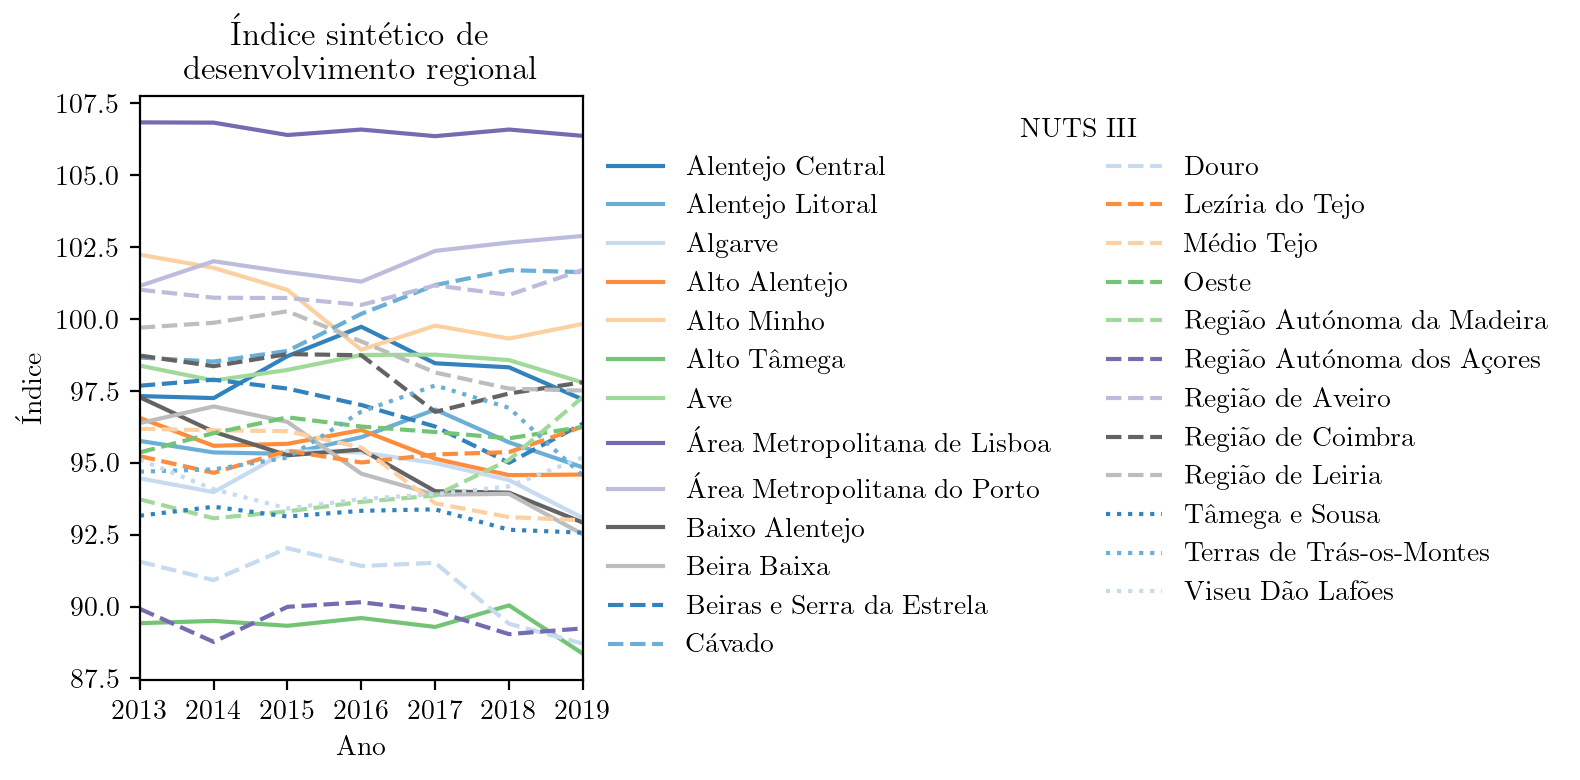

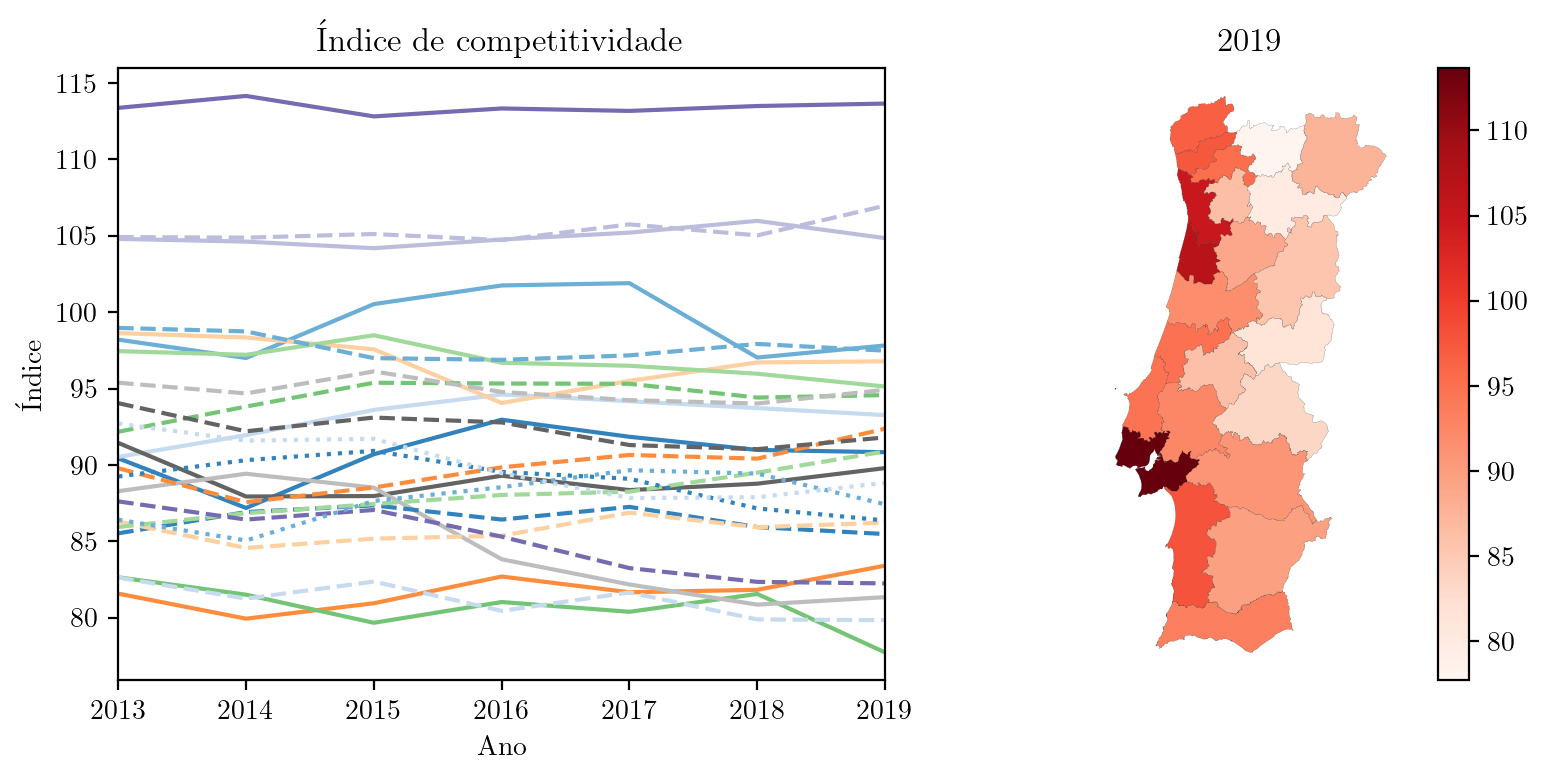

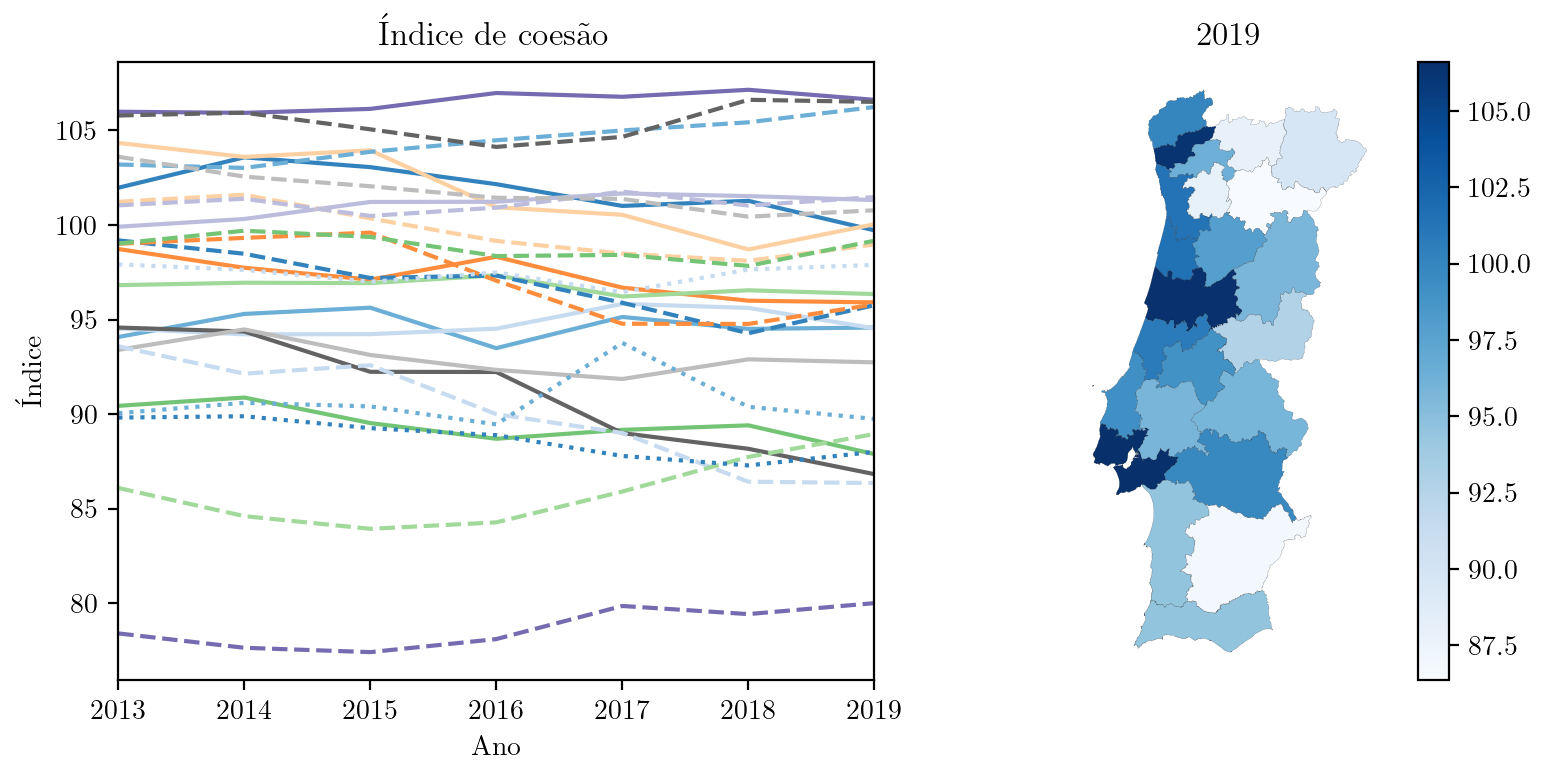

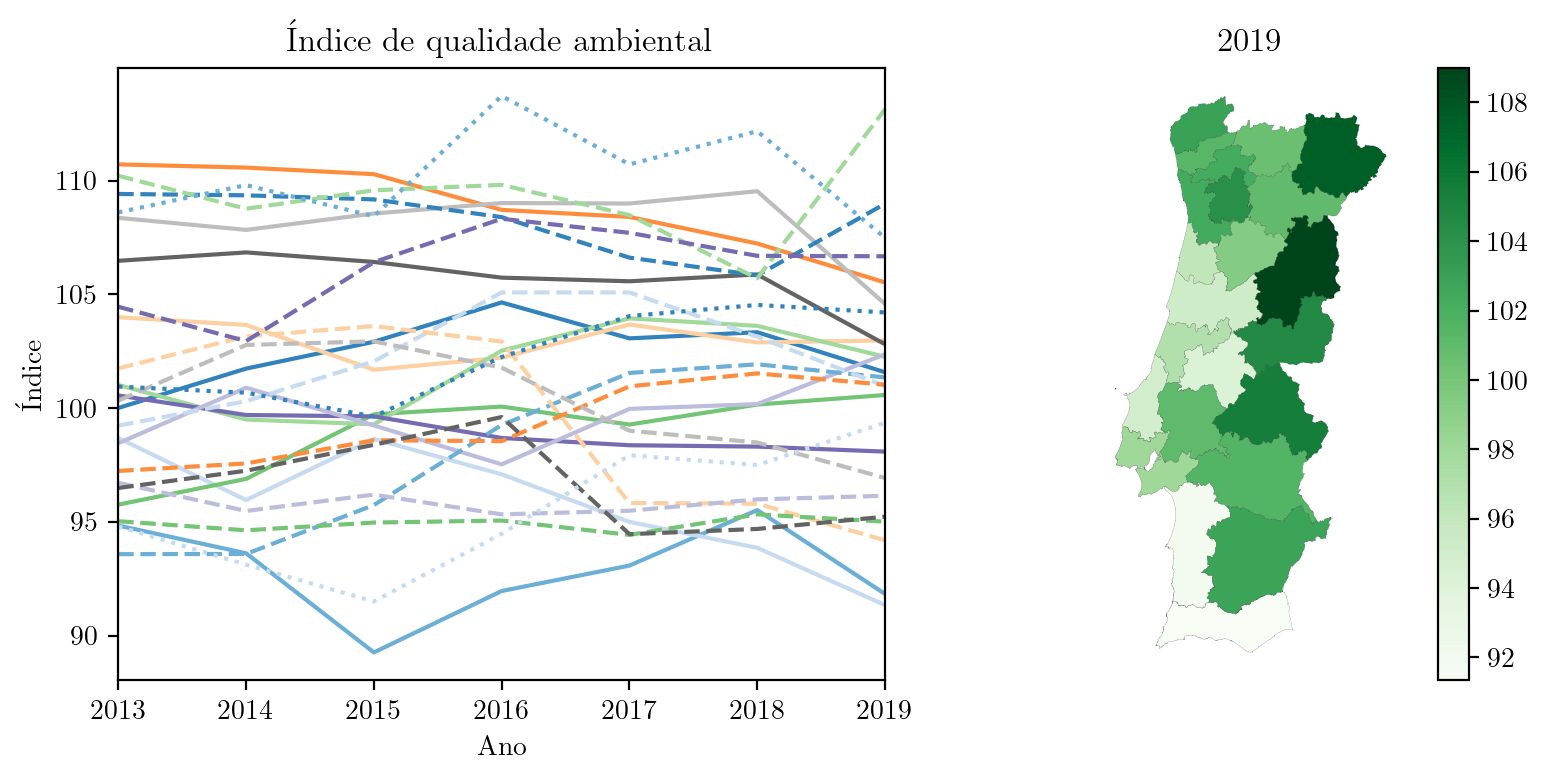

In [918]:
plotGeral(sintetico[sintetico.year>2012], 'sintetico')
plotSintetico(nuts, sintetico[sintetico.year>2012], 'competitividade', 'competitividade', 'Reds', 'sintetico_competitividade')
plotSintetico(nuts, sintetico[sintetico.year>2012], 'coesao', 'coesão', 'Blues', 'sintetico_coesao')
plotSintetico(nuts, sintetico[sintetico.year>2012], 'ambiente', 'qualidade ambiental', 'Greens', 'sintetico_ambiente')

In [630]:
def addColumn(geodf, dic): geo = geodf.copy(); geo['metric'] = geo.index.map(nut2name).map(dic); return geo

In [692]:
def plotClusterPT(geodf, df, color, filename, ncluster):

    mosaic = '''
    ACD
    BCD
    '''
    X = df[['competitividade', 'coesao', 'ambiente']] 
    
    f, ax = plt.subplot_mosaic(mosaic, constrained_layout=True, dpi=200, figsize=(8,4))
    
    pd.Series({x:KMeans(n_clusters=x, random_state=0).fit(X).inertia_ for x in range(2,20)}).plot(c='k', ax=ax['A'])
    ax['A'].set_title('Método do cotovelo'); 
    ax['A'].set_xlabel('Número de clusters'); ax['A'].set_ylabel('Inércia')
    ax['A'].axvline(ncluster, linestyle=':', c='k')

    kmeans = KMeans(n_clusters=ncluster, random_state=0).fit(X).labels_
    mapper = umap.UMAP(n_neighbors=30, min_dist=0.0, n_components=2, random_state=42,).fit(X)
    mapped = mapper.transform(X)
    ax['B'].scatter(mapped[:,0], mapped[:,1], s=0.5, c=kmeans, cmap=color)
    ax['B'].set_xticks([]); ax['B'].set_yticks([])
    ax['B'].set_title('Redução de dimensões')
    
    addColumn(geodf, pd.Series(kmeans, index=df.nut3).iloc[(df.year==2013).tolist()].to_dict())\
    .plot(column='metric', ax=ax["C"], cmap=color, edgecolor="k", linewidth=0.05)
    ax["C"].set_axis_off(); ax["C"].set_title(2013)
    # texts = nuts.apply(lambda x: ax["C"].annotate(text=x['Des_Simpli'], xy=x.geometry.centroid.coords[0], ha='center', size=8), axis=1)
    # adjust_text(texts, arrowprops=dict(arrowstyle='->', color='k'), ax=ax["C"])
    
    addColumn(geodf, pd.Series(kmeans, index=df.nut3).iloc[(df.year==2019).tolist()].to_dict())\
    .plot(column='metric', ax=ax["D"], cmap=color, edgecolor="k", linewidth=0.05)
    ax["D"].set_axis_off(); ax["D"].set_title(2019)
    # texts = nuts.apply(lambda x: ax["D"].annotate(text=x['Des_Simpli'], xy=x.geometry.centroid.coords[0], ha='center', size=8), axis=1)
    # adjust_text(texts, arrowprops=dict(arrowstyle='->', color='k'), ax=ax["D"])
    
    for filetype in ["png","pdf"]: plt.savefig(f'graphs/{filename}_{ncluster}.{filetype}', dpi=200, bbox_inches='tight')
    plt.show()

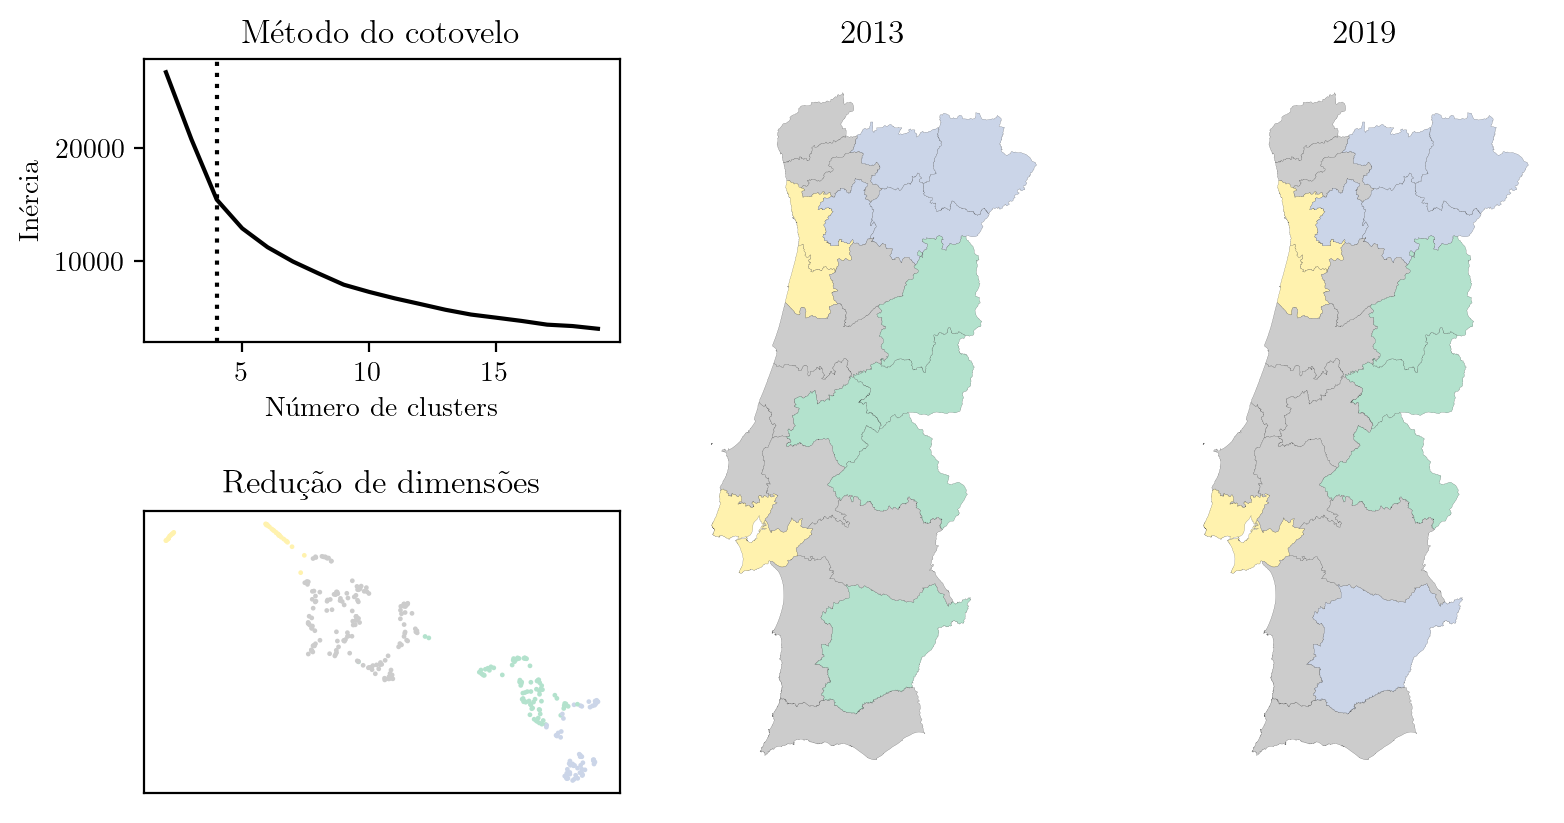

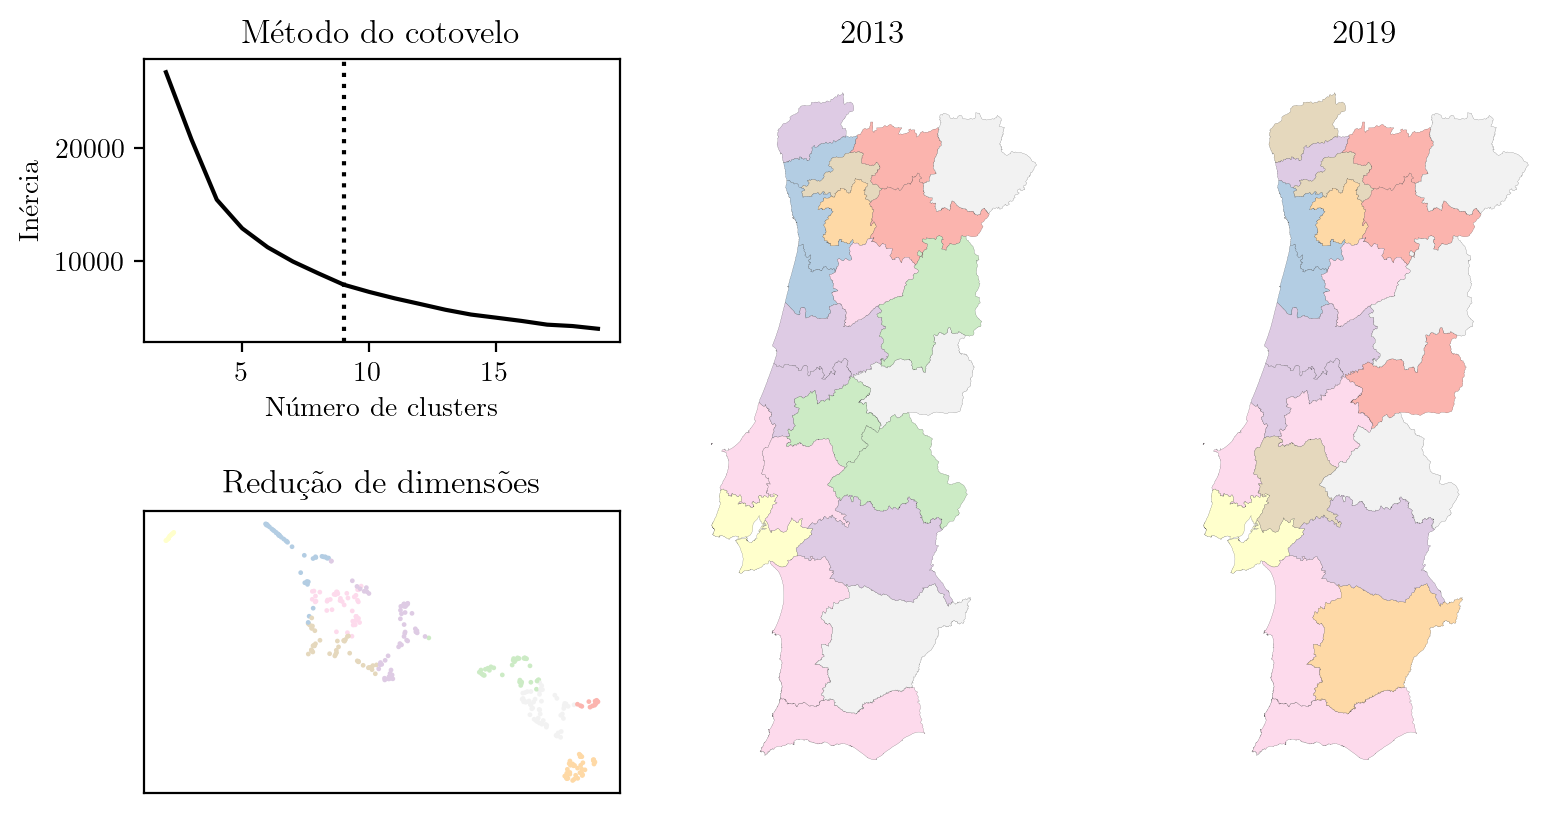

In [693]:
plotClusterPT(nuts, sintetico, 'Pastel2', 'pt', 4)
plotClusterPT(nuts, sintetico, 'Pastel1', 'pt', 9)

In [903]:
"PERFIS DE ESPECIALIZAçÃO REGIONAL: DISPARIDADE, FACE A PORTUGAL, DO VAB POR RAMO DEACTIVIDADE, POR NUTS II, 2001".lower()

'perfis de especialização regional: disparidade, face a portugal, do vab por ramo deactividade, por nuts ii, 2001'

In [648]:
def getColors(cmap, n): return [plt.get_cmap(cmap)(1. * i/n) for i in range(n)]

# Stat

In [919]:
def plotStat(data, geodf, titulo, ylabel, color, filename):
    f, ax = plt.subplots(1, 2, dpi=200, figsize=(8,4)); ax = ax.flatten()

    n = 11; new_colors = [plt.get_cmap('tab20c')(1. * i/n) for i in range(n)]
    
    ax[0].set_prop_cycle(cycler('linestyle', ['-', '--',':', '-.']) *cycler('color', new_colors)) 
    data.plot(ax=ax[0]);
    ax[0].set_xlabel("Ano"); ax[0].set_ylabel(ylabel); ax[0].get_legend().remove()
    ax[0].set_title(f'{titulo}'); 
    
    addColumn(geodf, data.sort_index().iloc[-1].to_dict())\
    .plot(column='metric', ax=ax[1], legend=True, cmap=color, edgecolor="k", linewidth=0.05)
    ax[1].set_axis_off(); ax[1].set_title(data.sort_index().index.astype(str).str[:4][-1])

    plt.tight_layout()
    for filetype in ["png","pdf"]: plt.savefig(f'graphs/{filename}.{filetype}', dpi=200, bbox_inches='tight')
    plt.show()

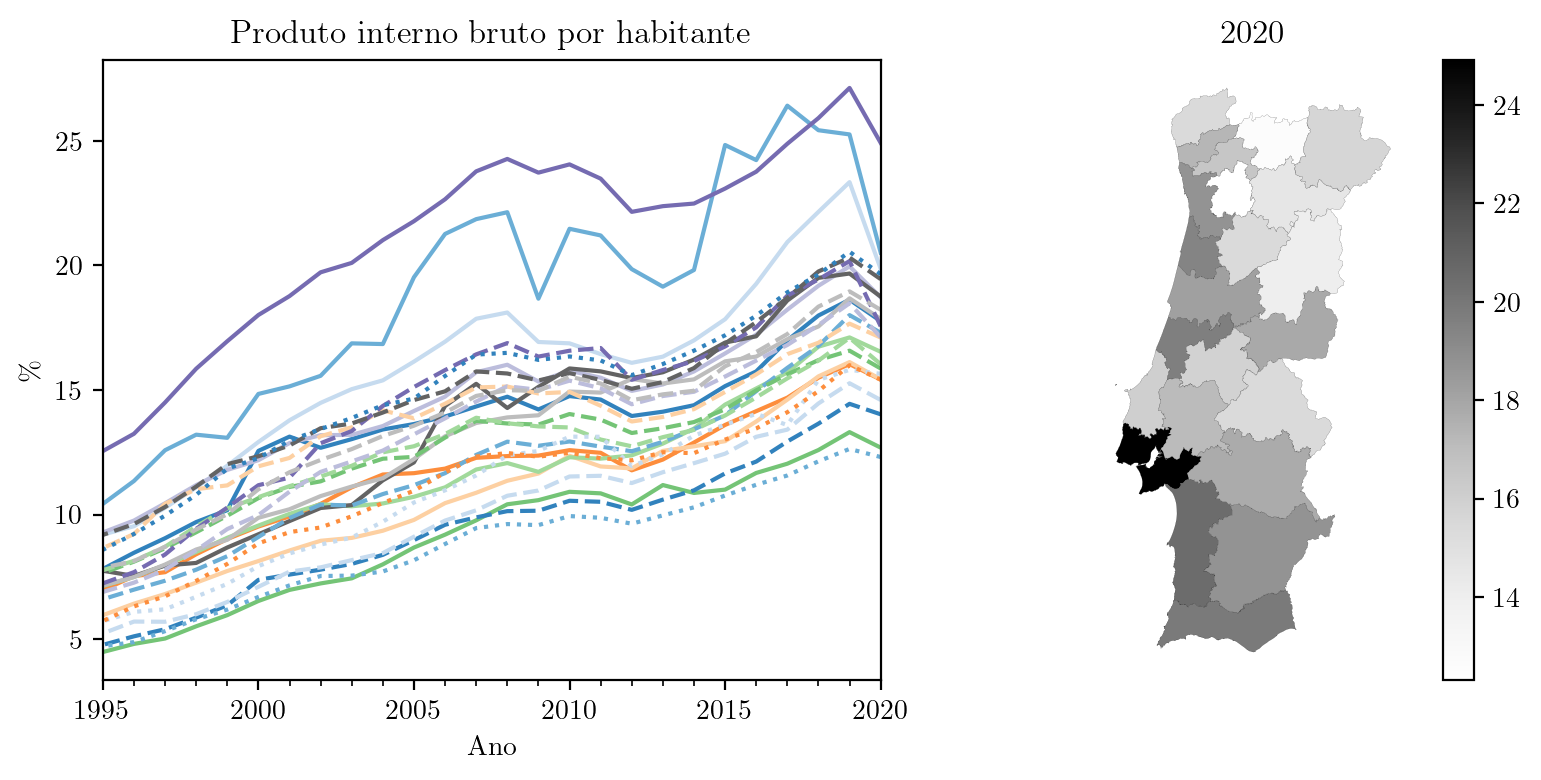

In [920]:
plotStat(convertTime(sortColumns(pd.read_csv(f'data/{"pib"}.csv', index_col=0).T)), 
         nuts, 'Produto interno bruto por habitante', '\%', 'Greys', 'pib')

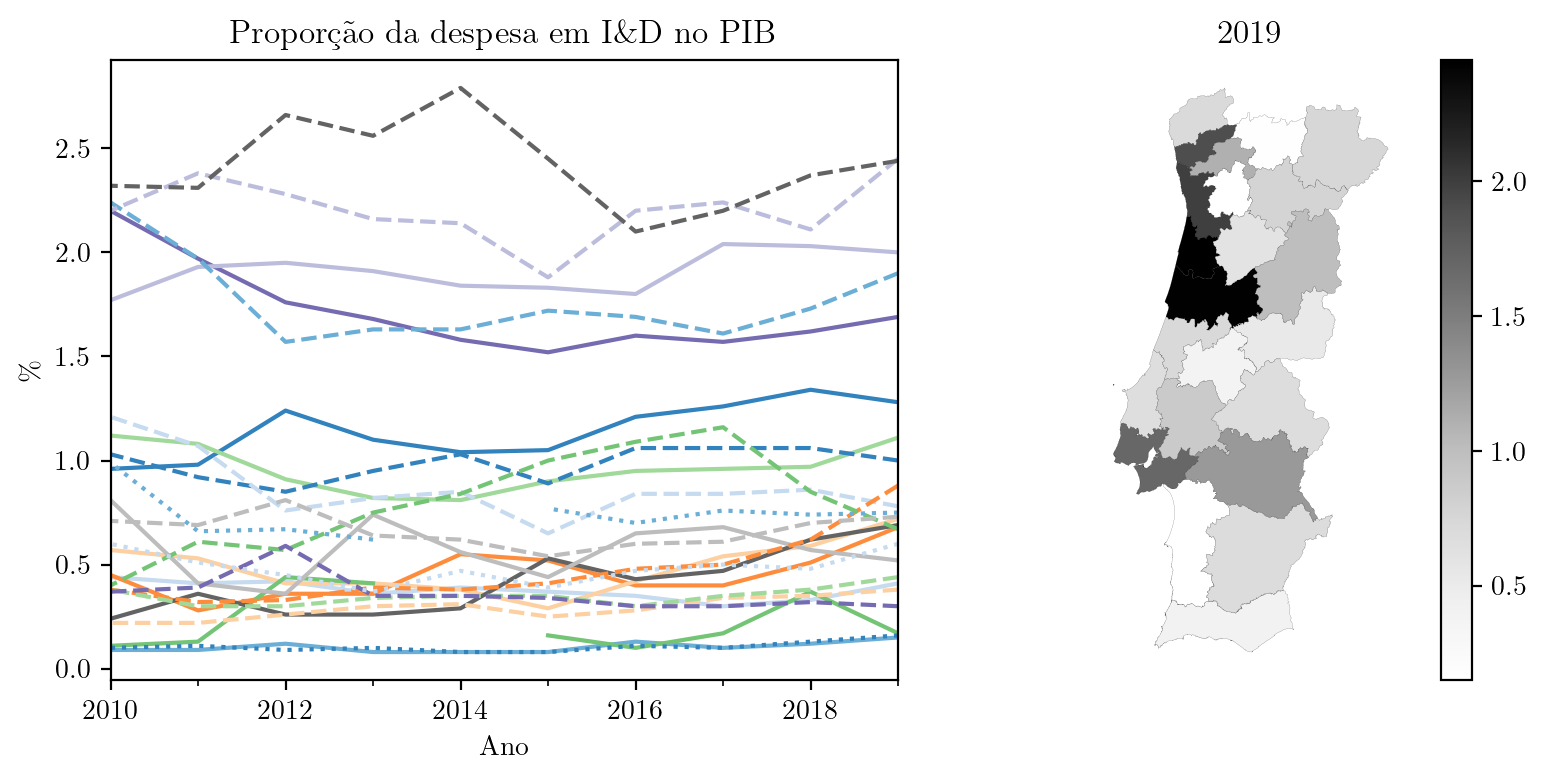

In [921]:
plotStat(convertTime(sortColumns(pd.read_csv(f'data/{"id"}.csv', index_col=0).T)), 
         nuts, 'Proporção da despesa em I\&D no PIB', '\%', 'Greys', 'id')

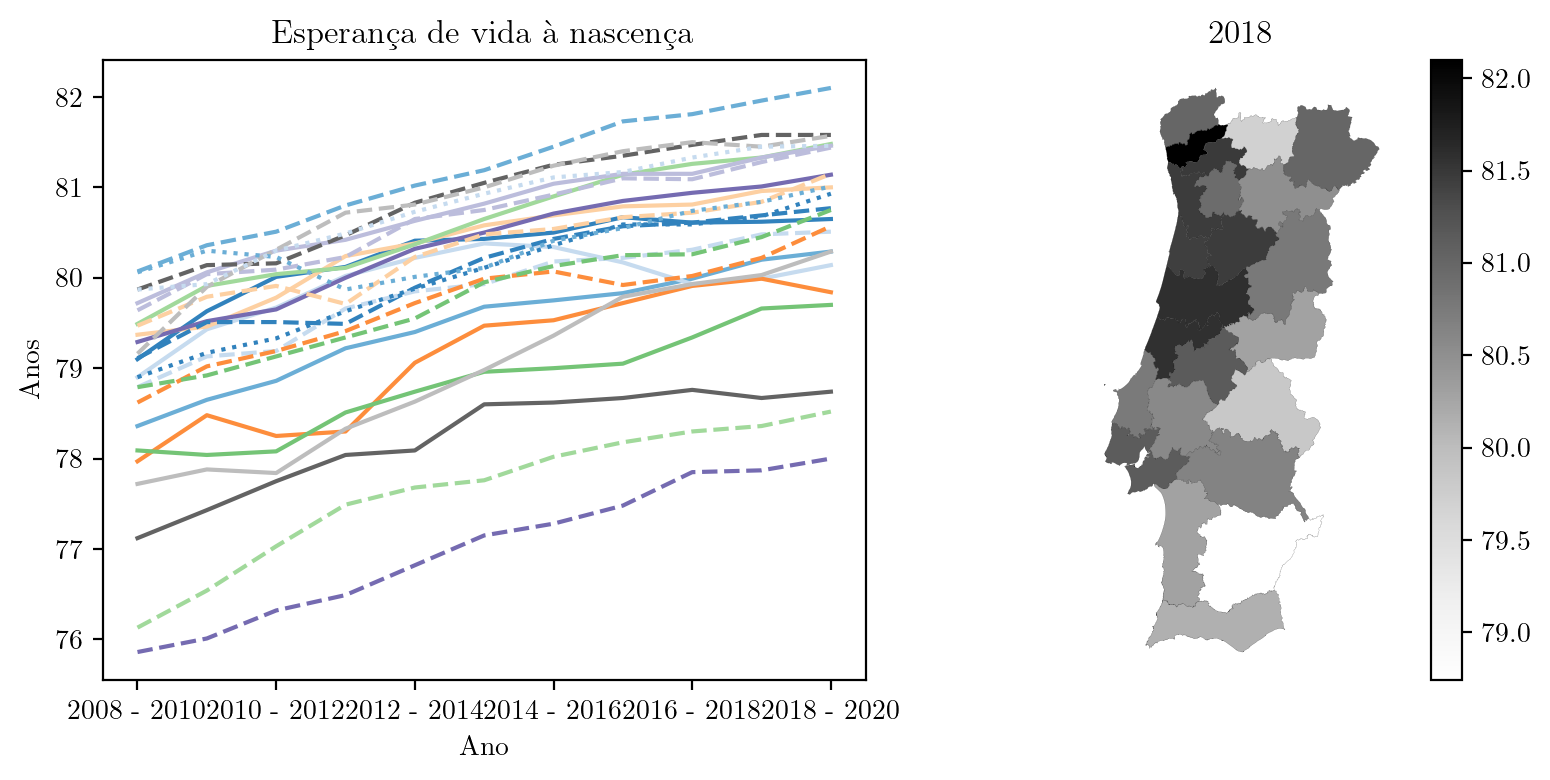

In [922]:
plotStat(sortColumns(pd.read_csv(f'data/{"life"}.csv', index_col=0).T.sort_index()), 
         nuts, 'Esperança de vida à nascença', 'Anos', 'Greys', 'life')

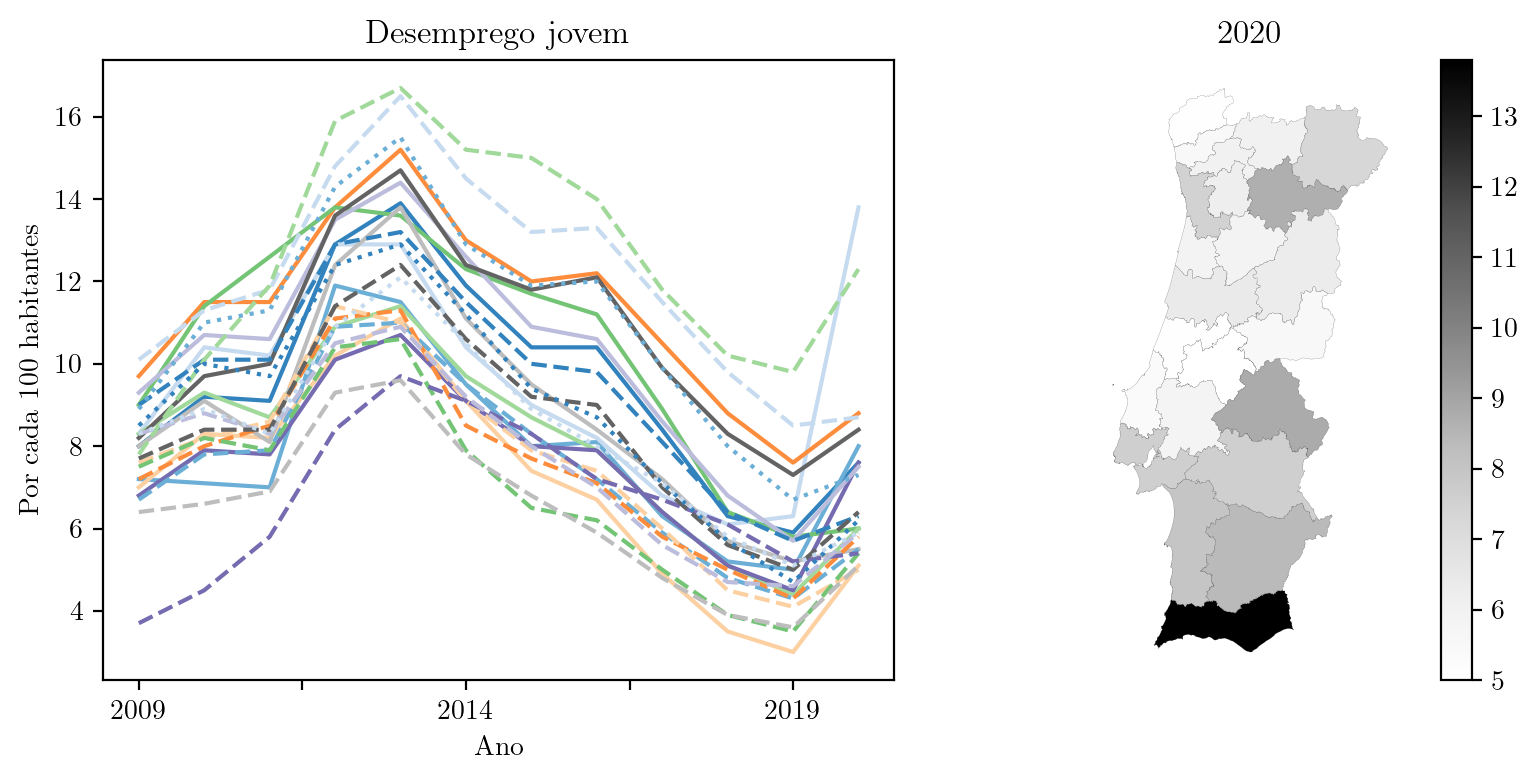

In [923]:
plotStat(sortColumns(pd.read_csv(f'data/{"youth"}.csv', index_col=0).T.sort_index()), 
         nuts, 'Desemprego jovem', 'Por cada 100 habitantes', 'Greys', 'youth')

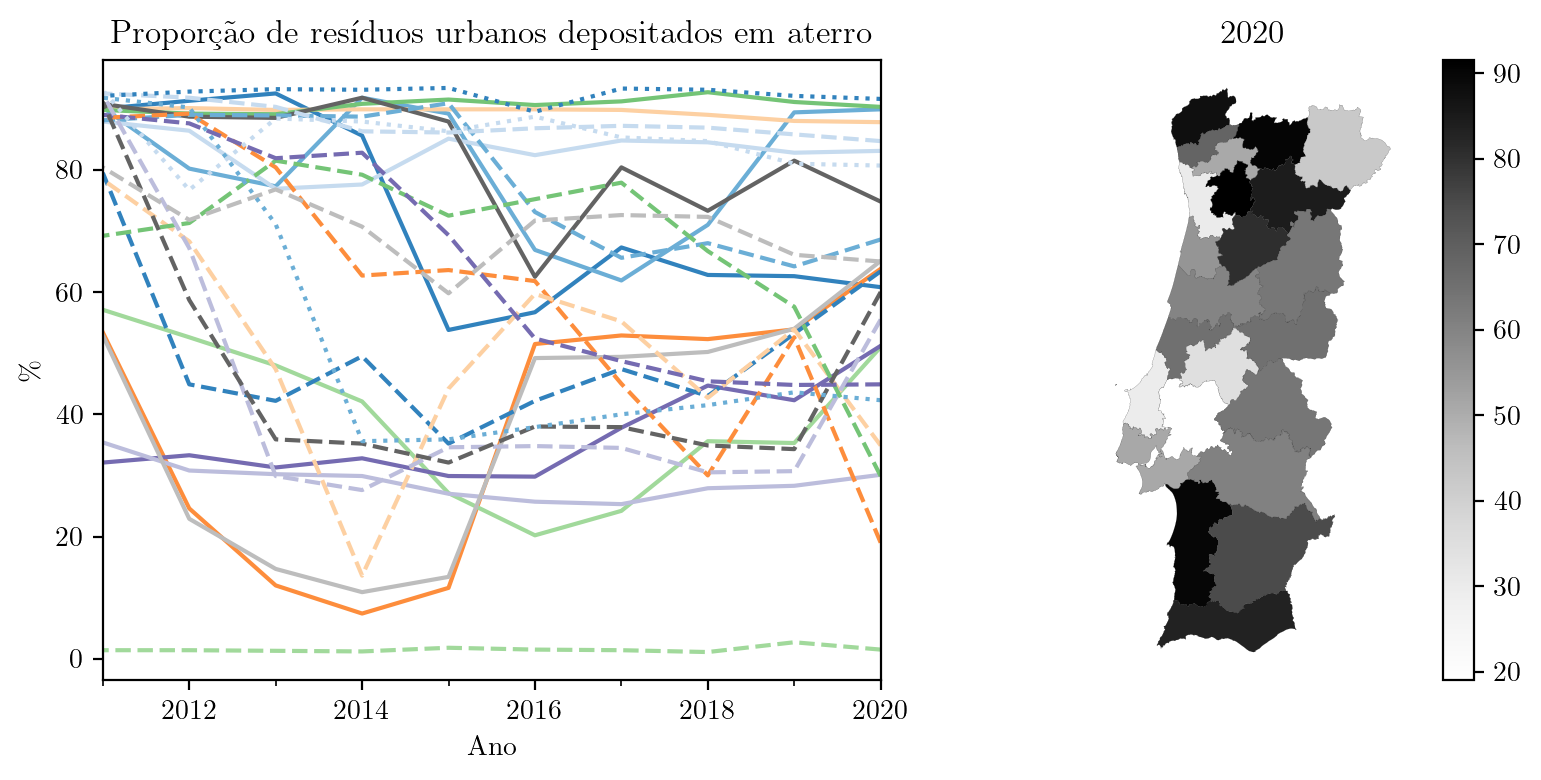

In [924]:
plotStat(convertTime(sortColumns(pd.read_csv(f'data/{"residuos"}.csv', index_col=0).T)), 
         nuts, 'Proporção de resíduos urbanos depositados em aterro', '\%', 'Greys', 'residuos')

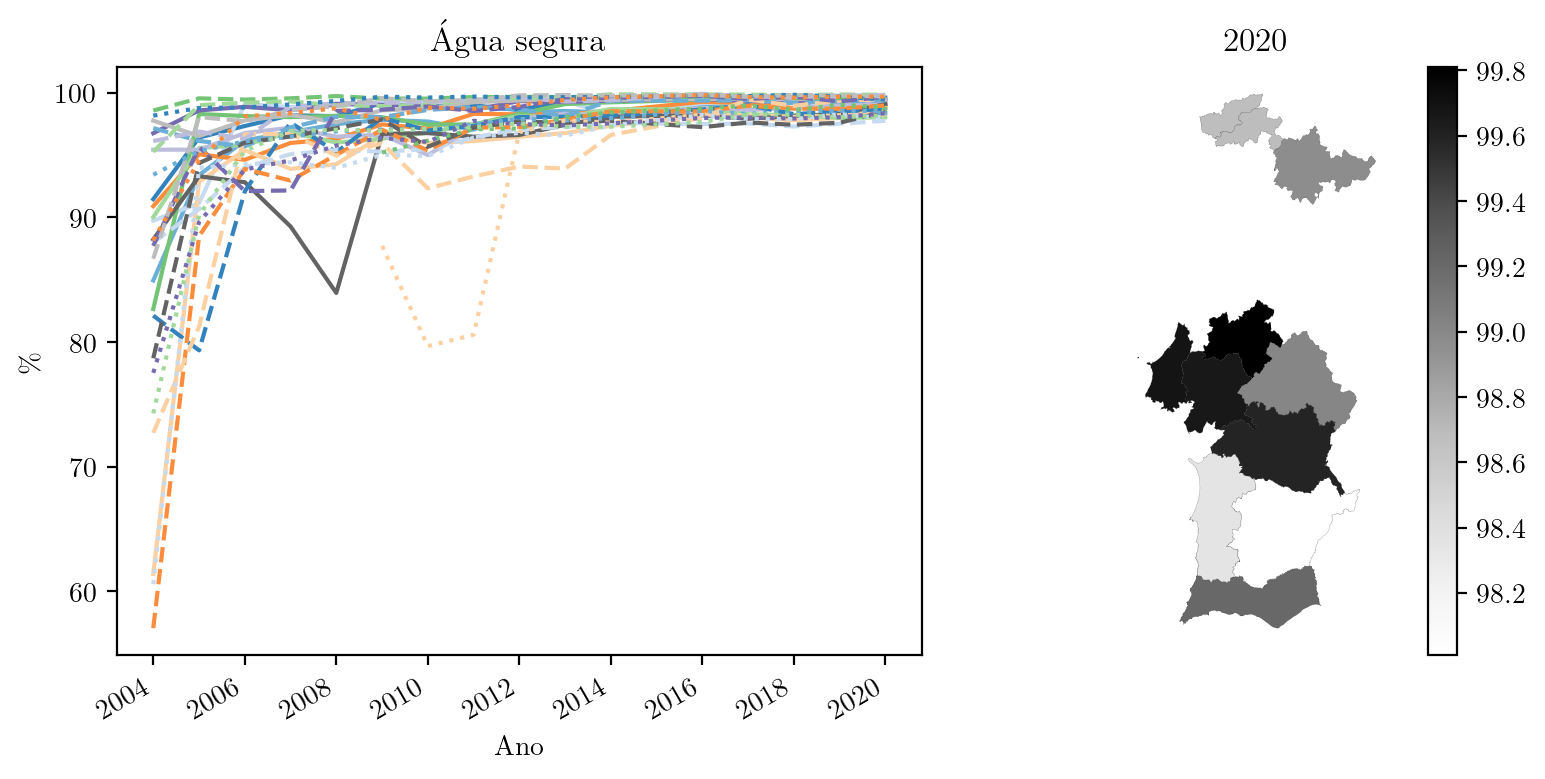

In [925]:
plotStat(convertTime(sortColumns(pd.read_csv(f'data/{"water"}.csv', index_col=0).T)), 
         nuts, 'Água segura', '\%', 'Greys', 'water')